In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time as t
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.cuda import amp
import pandas as pd
import tqdm
plt.style.use('bmh')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchsummary import summary
torch.backends.cudnn.deterministic = True
np.random.seed(4000)
torch.manual_seed(4000)

/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'1.12.1'

# Dataset

## Class

In [3]:
Mnist_classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
KMnist_classes = ('お', 'き', 'す', 'つ',
           'な', 'は', 'ま', 'や', 'れ', 'を')
flower_calsses = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [4]:
def choise_transform(mode, epoch=-1):
    rgb_mode = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                   transforms.CenterCrop(400),
                                   transforms.Resize(200)
                                   ])
    gray_mode = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])


    if epoch<0:
        if mode == 'gray_normal':
            return gray_mode
        if mode == 'RGB_normal':
            return rgb_mode


    elif epoch<30:
        randlist = []
        for i in range(6):
            if np.random.rand(1)<0.6:
                randlist.append(i)

        return add_transform([0,1,2,3,4])
    elif epoch<40:
        randlist = []
        for i in range(5):
            if np.random.rand(1)<0.6:
                randlist.append(i)
        return add_transform([0,1,2,3])
    elif epoch<45:
        return add_transform([0,1,2])
    elif epoch<47:
        return None
    # else:
    #     return None
    # transforms.Resize((200, 200))

In [5]:
def add_transform(translist=[]):
    transformsList = [transforms.RandomRotation(45,center=None),
                      transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomVerticalFlip(p=0.5),
                      transforms.RandomResizedCrop(size=200, scale=(0.5, 2)),
                      transforms.RandomAffine(degrees=0, shear=(0, 0, 0, 45)),
                      transforms.ColorJitter(hue=0.1),
                      ]

    new_transform = [transforms.ToTensor(),
                     ]
    for i in translist:
        new_transform.append(transformsList[i])
    return transforms.Compose(new_transform)

In [6]:
# Mnist dataset
transform = choise_transform('gray_normal')
Mnist_trainSet = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
Mnist_testSet = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#KMnist dataset
KMnist_trainSet = datasets.KMNIST(root='./data', download=True, train=True, transform=transform)
KMnist_testSet = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

#Flowers102 dataset
transform = choise_transform('RGB_normal')
flower_trainSet = datasets.Flowers102(root='./data', download=True, split = 'test', transform=transform)
flower_testSet = datasets.Flowers102(root='./data', split = 'train', download=True, transform=transform)


if flower_trainSet[0][1] == 1:
    minus1 = True

In [7]:
Mnist_trainloader = torch.utils.data.DataLoader(Mnist_trainSet, batch_size=64,
                                          shuffle=True, num_workers=4)
Mnist_testloader = torch.utils.data.DataLoader(Mnist_testSet, batch_size=64,
                                          shuffle=False, num_workers=4)

KMnist_trainloader = torch.utils.data.DataLoader(KMnist_trainSet, batch_size=64,
                                          shuffle=True, num_workers=4)
KMnist_testloader = torch.utils.data.DataLoader(KMnist_testSet, batch_size=64,
                                          shuffle=False, num_workers=4)

flower_trainloader = torch.utils.data.DataLoader(flower_trainSet, batch_size=64,
                                          shuffle=True, num_workers=4)
flower_testloader = torch.utils.data.DataLoader(flower_testSet, batch_size=64,
                                          shuffle=False, num_workers=4)

## show data

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lotus anthurium corn poppy daffodil great masterwort


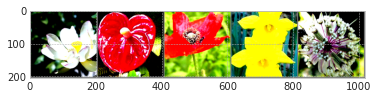

In [9]:
# get some random training images
dataiter = iter(flower_trainloader)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid([images[i] for i in range(5)], padding=3))
# print labels
print(' '.join('%5s' % flower_calsses[labels[j]] for j in range(5)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


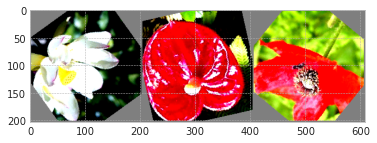

In [10]:
img_cp = images.clone()
l1_transform = choise_transform('RGB_normal', 44)
for idx in range(len(labels)):
    img_cp[idx] = l1_transform(img_cp[idx].permute(1, 2, 0).numpy())
imshow(torchvision.utils.make_grid([img_cp[0],img_cp[1], img_cp[2]]))

    4     3     2     6     2


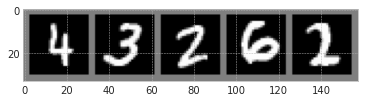

In [11]:
# get some random training images
dataiter = iter(Mnist_trainloader)
images, labels = dataiter.next()
imgList = []
#[i for i in range(5)]
imshow(torchvision.utils.make_grid([images[i] for i in range(5)], padding=3))
# print labels
print(' '.join('%5s' % Mnist_classes[labels[j]] for j in range(5)))

    つ     れ     な     な     き


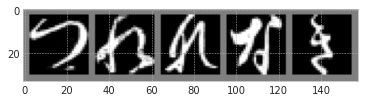

In [12]:
# get some random training images
dataiter = iter(KMnist_trainloader)
images, labels = dataiter.next()
imgList = []
#[i for i in range(5)]
imshow(torchvision.utils.make_grid([images[i] for i in range(5)], padding=3))
# print labels
print(' '.join('%5s' % KMnist_classes[labels[j]] for j in range(5)))

In [13]:
device = torch.cuda.set_device(2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 2 NVIDIA GeForce RTX 2080 Ti


In [14]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [15]:
class ResidualBolck(nn.Module):
    def __init__(self, in_channels, out_channels, activate_F):
        super(ResidualBolck, self).__init__()
        self.activate_F = activate_F
        printL = PrintLayer()
        
        self.main = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                self.choise_activate(),
                nn.Dropout(0.3),

                nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                
        )   
    def choise_activate(self):
        if self.activate_F == 'relu':
            return nn.ReLU()
        elif self.activate_F == 'leaky_r':
            return nn.LeakyReLU()
        elif self.activate_F == 'elu':
            return nn.ELU()
    def forward(self, input):
        out = input + self.main(input)
        #out = self.choise_activate()
        return out

In [16]:
class my_mnist_Net(nn.Module):


    def __init__(self, activate_F):
        super(my_mnist_Net, self).__init__()
        self.activate_F = activate_F
        printL = PrintLayer()

        # input : 3 X 28 X 28

        #(width + pad*2 - kernel)/stride + 1


        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(16),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            #printL,

            nn.Conv2d(16, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),


            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.Linear(128, 10),
        )

    def choise_activate(self):
        if self.activate_F == 'relu':
            return nn.ReLU()
        elif self.activate_F == 'leaky_r':
            return nn.LeakyReLU()
        elif self.activate_F == 'elu':
            return nn.ELU()
    def forward(self, input):
        return self.main(input)

In [17]:
net = my_mnist_Net('elu').to(device)
summary(net, (1, 28, 28))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cuda:0! (when checking argument for argument weight in method wrapper__cudnn_convolution)

In [18]:
class flower_Net(nn.Module):
    def __init__(self, resBolck, activate_F):
        super(flower_Net, self).__init__()
        # input : 3 X 32 X 32
        self.activate_F = activate_F
        printL = PrintLayer()
        self.res = resBolck
        #(width + pad*2 - kernel)/stride + 1
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            self.res(256, 256, self.activate_F),
            self.choise_activate(),
            
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            

            self.res(512, 512, self.activate_F),
            self.choise_activate(),
            
            
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            self.res(256, 256, self.activate_F),
            self.choise_activate(),
            
            nn.Conv2d(256, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            #printL,
            
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 2048),
            nn.Linear(2048, 512),
            nn.Linear(512, 102),
        )
        
    def choise_activate(self):
        if self.activate_F == 'relu':
            return nn.ReLU()
        elif self.activate_F == 'leaky_r':
            return nn.LeakyReLU(0.2)
        elif self.activate_F == 'elu':
            return nn.ELU()

    def forward(self, input):
        return self.main(input)

In [19]:
# net = flower_Net(ResidualBolck, 'leaky_r').to(device)
# summary(net, (3, 200, 200))

# functions

## train&test_part

In [20]:
def train_part(net, trainloader, testloader, criterion, optimizer, epochs, add_data=False):
    total_t = 0
    # writer = SummaryWriter(log_dir)
    iters = 0
    losses = []
    accs = []
    scaler = amp.GradScaler()
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        start_time = t.time()
        mean_loss = 0.0
        batch_loss = 0
        for i, data in enumerate(trainloader, 0):

            net.train()    

            # get the inputs
            inputs, labels = data[0], data[1].to(device)
#             if minus1:
#                 labels -= 1

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            inputs_cp = inputs.detach().clone()

            if add_data:
                level_transform = choise_transform('', epoch)
                if level_transform!=None:
                    for idx in range(len(labels)):
                        inputs_cp[idx] = level_transform(inputs_cp[idx].permute(1, 2, 0).numpy())

            
            
            with amp.autocast():
                outputs = net(inputs_cp.to(device))
                loss = criterion(outputs, labels)
            
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            # print statistics
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            mean_loss += loss.item()
            
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}, MeanLoss:{mean_loss/(i+1):.3f}", end='')
            # batch_szie = labels.size(0)
            # batch_loss += loss.item()
            losses.append(mean_loss/(i+1))
            #writer.add_scalar('Loss', loss.item(), iters)
            
            iters += 1
        accs.append(test_part(net, testloader))
        
        end_time = t.time()
        total_t +=  end_time - start_time
        #schedul.step()
        #print(f'time : {end_time - start_time}')

    print(f'\tTotal_time : {total_t/60} Mins')
    plot_result(losses, 'Loss')
    plot_result(accs, 'Accuracy')
def test_part(net, test_loader):
    
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
#             if minus1:
#                 labels -= 1
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
    acc = (100 * correct / total)

    print('\n\tAccuracy of the network on the 10000 test images: %.3f %%' % acc)
    return acc

In [21]:
def choise_net(my_Net):
    return my_Net().to(device)
def plot_result(results,label):
    plt.figure(figsize=(10,5))
    plt.title(label)
    plt.plot(results,label=label)
    plt.xlabel("iterations")
    plt.ylabel(label)
    plt.legend()
    plt.show()
def weights_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
def choise_net(Net, activate_f, use_res):
    if use_res:
        return Net(ResidualBolck, activate_f).to(device)
    else:
        return Net(activate_f).to(device)
def choise_optim(Net, opt):

    if (opt == 'sgd'):
        return optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)
    elif (opt == 'adam'):
        opt = optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        schedul = optim.lr_scheduler.MultiStepLR(opt, milestones=[60, 80 , 95], gamma=0.1)
        return opt, schedul
    elif (opt == 'adamW'):
        return optim.AdamW(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,)

def show_result(net, testloader, classes):
    preds = np.zeros((1))
    truth = np.zeros((1))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted.cpu() == labels).squeeze()
            preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
            truth = np.concatenate([truth, labels.numpy()], axis=0)

    arr = confusion_matrix(truth, preds)
    df_cm = pd.DataFrame(arr, classes, classes)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")

In [22]:
CrossEntropy = nn.CrossEntropyLoss()
activate_f_list = ['relu', 'leaky_r', 'elu']

In [23]:
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 2 NVIDIA GeForce RTX 2080 Ti



Epoch:1
	Batch:938 of 938, loss:0.138, MeanLoss:0.366
	Accuracy of the network on the 10000 test images: 96.640 %

Epoch:2
	Batch:938 of 938, loss:0.044, MeanLoss:0.152
	Accuracy of the network on the 10000 test images: 97.670 %

Epoch:3
	Batch:938 of 938, loss:0.068, MeanLoss:0.120
	Accuracy of the network on the 10000 test images: 98.020 %

Epoch:4
	Batch:938 of 938, loss:0.011, MeanLoss:0.107
	Accuracy of the network on the 10000 test images: 98.380 %

Epoch:5
	Batch:938 of 938, loss:0.039, MeanLoss:0.097
	Accuracy of the network on the 10000 test images: 98.220 %
	Total_time : 0.8253332495689392 Mins


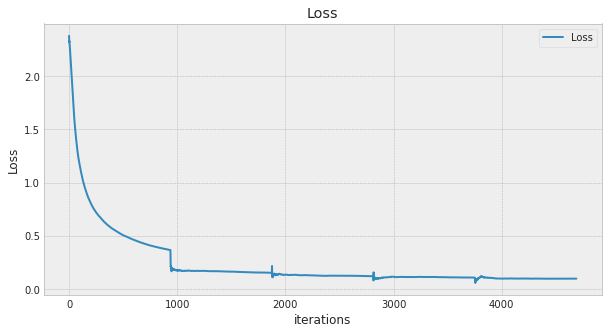

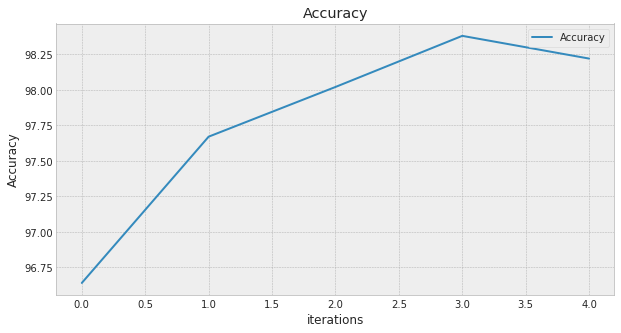

	Activate function : relu

Epoch:1
	Batch:938 of 938, loss:0.373, MeanLoss:0.365
	Accuracy of the network on the 10000 test images: 96.530 %

Epoch:2
	Batch:938 of 938, loss:0.132, MeanLoss:0.157
	Accuracy of the network on the 10000 test images: 97.490 %

Epoch:3
	Batch:938 of 938, loss:0.035, MeanLoss:0.125
	Accuracy of the network on the 10000 test images: 97.890 %

Epoch:4
	Batch:938 of 938, loss:0.224, MeanLoss:0.111
	Accuracy of the network on the 10000 test images: 98.000 %

Epoch:5
	Batch:938 of 938, loss:0.215, MeanLoss:0.100
	Accuracy of the network on the 10000 test images: 98.310 %
	Total_time : 0.78238605260849 Mins


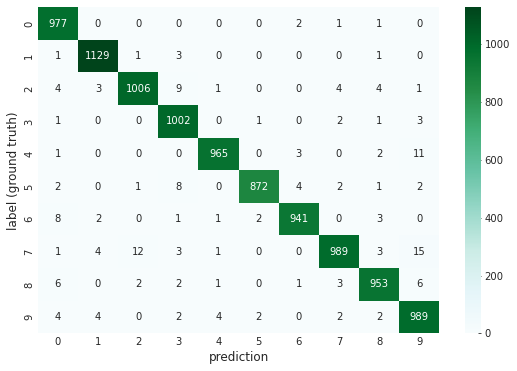

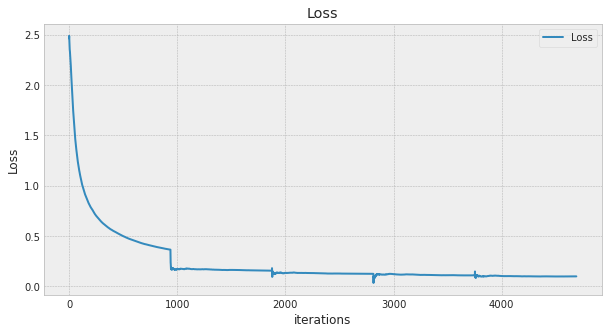

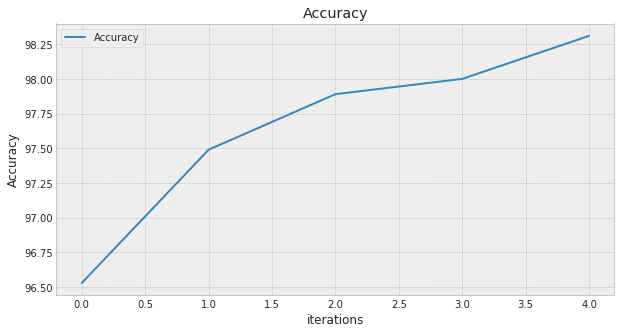

	Activate function : leaky_r

Epoch:1
	Batch:938 of 938, loss:0.424, MeanLoss:0.380
	Accuracy of the network on the 10000 test images: 96.320 %

Epoch:2
	Batch:938 of 938, loss:0.099, MeanLoss:0.160
	Accuracy of the network on the 10000 test images: 97.100 %

Epoch:3
	Batch:938 of 938, loss:0.017, MeanLoss:0.128
	Accuracy of the network on the 10000 test images: 97.790 %

Epoch:4
	Batch:938 of 938, loss:0.059, MeanLoss:0.109
	Accuracy of the network on the 10000 test images: 98.030 %

Epoch:5
	Batch:938 of 938, loss:0.016, MeanLoss:0.098
	Accuracy of the network on the 10000 test images: 98.210 %
	Total_time : 0.7701400597890218 Mins


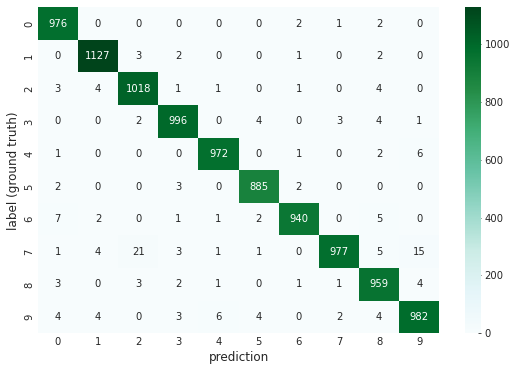

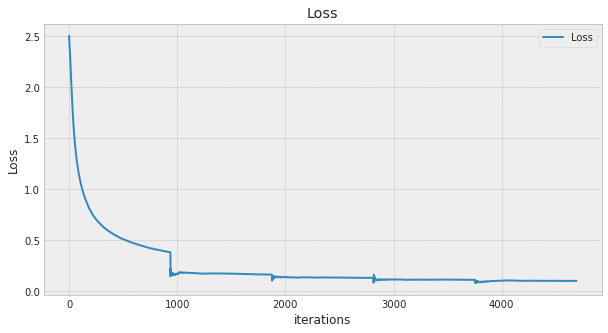

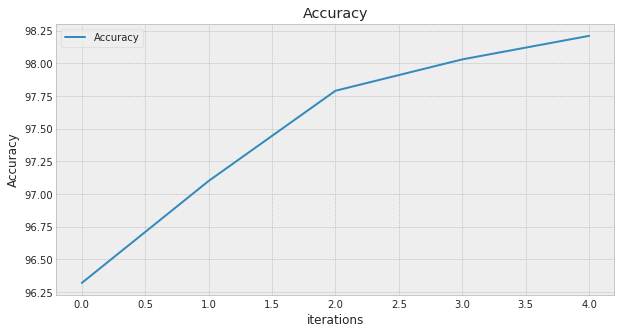

	Activate function : elu


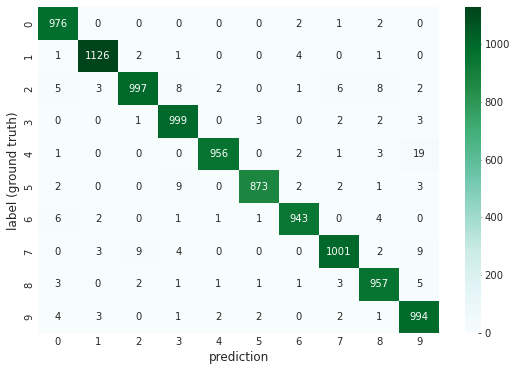

In [24]:
for f in activate_f_list:
    net2 = choise_net(my_mnist_Net, f, False) #original model
    net2.apply(weights_reset)
    Optim = choise_optim(net2, 'sgd')

    train_part(net2, Mnist_trainloader, Mnist_testloader, CrossEntropy, Optim, 5, False)
    show_result(net2, Mnist_testloader, Mnist_classes)
    print(f'\tActivate function : {f}')


Epoch:1
	Batch:938 of 938, loss:0.201, MeanLoss:0.450
	Accuracy of the network on the 10000 test images: 94.588 %

Epoch:2
	Batch:938 of 938, loss:0.287, MeanLoss:0.223
	Accuracy of the network on the 10000 test images: 96.317 %

Epoch:3
	Batch:938 of 938, loss:0.103, MeanLoss:0.178
	Accuracy of the network on the 10000 test images: 96.957 %

Epoch:4
	Batch:938 of 938, loss:0.044, MeanLoss:0.150
	Accuracy of the network on the 10000 test images: 97.712 %

Epoch:5
	Batch:938 of 938, loss:0.031, MeanLoss:0.131
	Accuracy of the network on the 10000 test images: 98.160 %
	Total_time : 1.1375240802764892 Mins


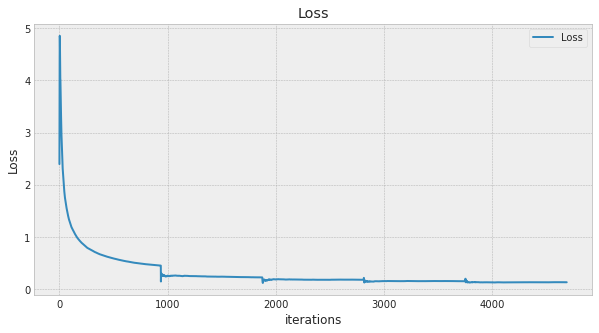

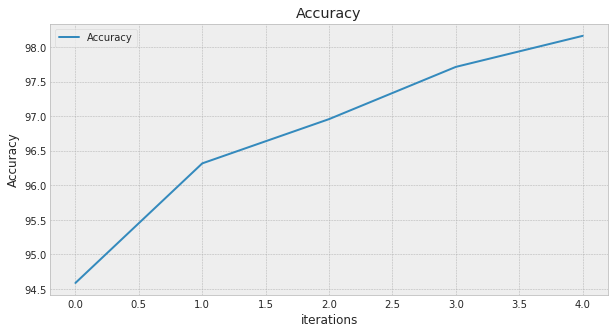

	Activate function : relu


/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph


Epoch:1
	Batch:938 of 938, loss:0.371, MeanLoss:0.431
	Accuracy of the network on the 10000 test images: 95.492 %

Epoch:2
	Batch:938 of 938, loss:0.199, MeanLoss:0.215
	Accuracy of the network on the 10000 test images: 96.255 %

Epoch:3
	Batch:938 of 938, loss:0.211, MeanLoss:0.172
	Accuracy of the network on the 10000 test images: 97.457 %

Epoch:4
	Batch:938 of 938, loss:0.084, MeanLoss:0.144
	Accuracy of the network on the 10000 test images: 97.727 %

Epoch:5
	Batch:938 of 938, loss:0.031, MeanLoss:0.125
	Accuracy of the network on the 10000 test images: 98.392 %
	Total_time : 1.1582466284434 Mins


/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missi

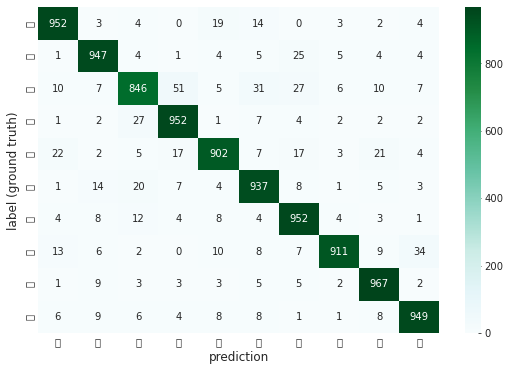

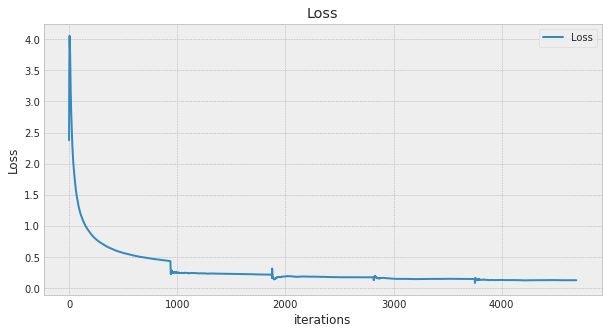

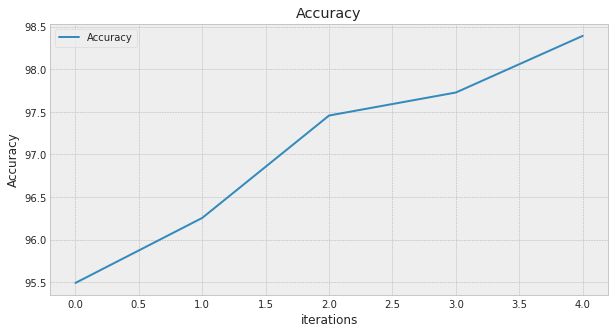

/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph

	Activate function : leaky_r

Epoch:1
	Batch:938 of 938, loss:0.156, MeanLoss:0.413
	Accuracy of the network on the 10000 test images: 94.790 %

Epoch:2
	Batch:938 of 938, loss:0.078, MeanLoss:0.231
	Accuracy of the network on the 10000 test images: 95.778 %

Epoch:3
	Batch:938 of 938, loss:0.036, MeanLoss:0.192
	Accuracy of the network on the 10000 test images: 96.850 %

Epoch:4
	Batch:938 of 938, loss:0.386, MeanLoss:0.171
	Accuracy of the network on the 10000 test images: 97.283 %

Epoch:5
	Batch:938 of 938, loss:0.197, MeanLoss:0.157
	Accuracy of the network on the 10000 test images: 97.413 %
	Total_time : 1.1391323804855347 Mins


/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missi

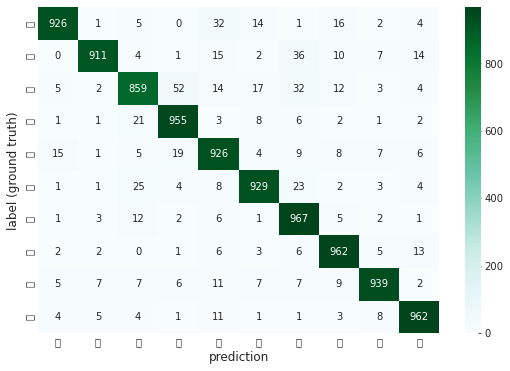

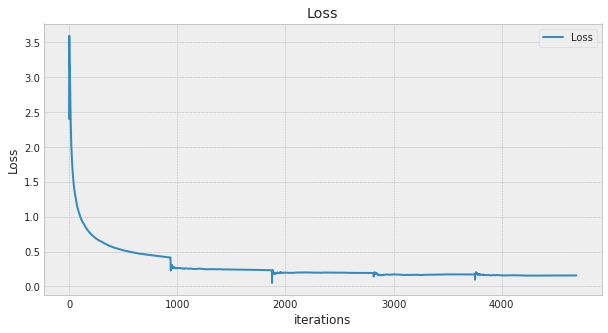

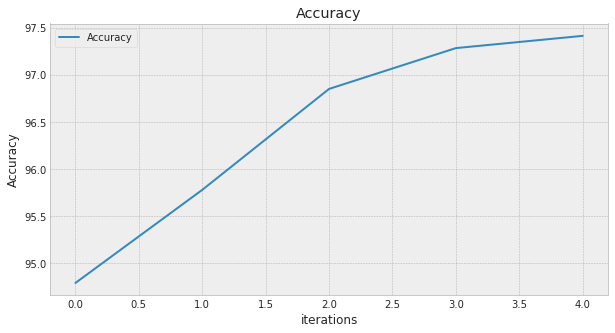

/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.draw()
/home/tapioca/miniconda3/envs/hw/lib/python3.10/site-packages/seaborn/utils.py:95: UserWarning: Glyph

	Activate function : elu


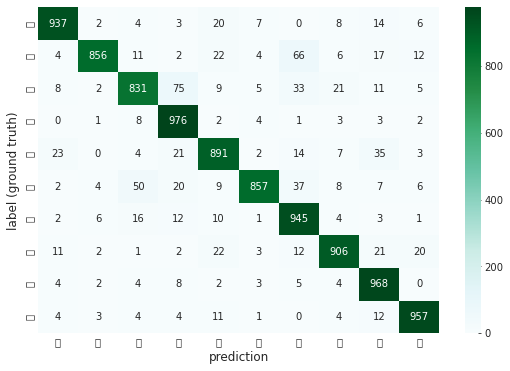

In [26]:
for f in activate_f_list:
    net3 = choise_net(my_mnist_Net, f, False) #original model
    net3.apply(weights_reset)
    Optim, schedul = choise_optim(net3, 'adam')

    train_part(net3, KMnist_trainloader, KMnist_trainloader, CrossEntropy, Optim, 5, False)
    show_result(net3, KMnist_testloader, KMnist_classes)
    print(f'\tActivate function : {f}')


Epoch:1
	Batch:097 of 97, loss:4.871, MeanLoss:5.2840
	Accuracy of the network on the 10000 test images: 2.843 %

Epoch:2
	Batch:097 of 97, loss:4.200, MeanLoss:3.893
	Accuracy of the network on the 10000 test images: 5.882 %

Epoch:3
	Batch:097 of 97, loss:5.075, MeanLoss:3.576
	Accuracy of the network on the 10000 test images: 8.431 %

Epoch:4
	Batch:097 of 97, loss:4.445, MeanLoss:3.541
	Accuracy of the network on the 10000 test images: 10.980 %

Epoch:5
	Batch:097 of 97, loss:3.560, MeanLoss:3.227
	Accuracy of the network on the 10000 test images: 14.706 %

Epoch:6
	Batch:097 of 97, loss:3.712, MeanLoss:3.007
	Accuracy of the network on the 10000 test images: 17.549 %

Epoch:7
	Batch:097 of 97, loss:1.930, MeanLoss:2.791
	Accuracy of the network on the 10000 test images: 18.529 %

Epoch:8
	Batch:097 of 97, loss:2.874, MeanLoss:2.899
	Accuracy of the network on the 10000 test images: 18.235 %

Epoch:9
	Batch:097 of 97, loss:4.906, MeanLoss:2.704
	Accuracy of the network on the 1000

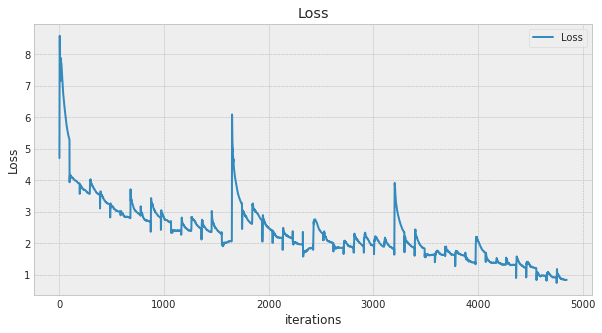

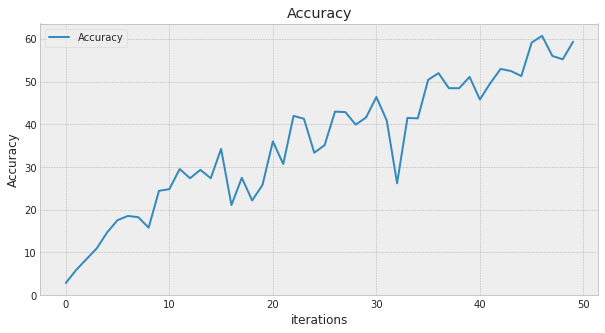

	Activate function : relu

Epoch:1
	Batch:097 of 97, loss:3.598, MeanLoss:5.62334
	Accuracy of the network on the 10000 test images: 2.745 %

Epoch:2
	Batch:097 of 97, loss:5.269, MeanLoss:3.816
	Accuracy of the network on the 10000 test images: 4.412 %

Epoch:3
	Batch:097 of 97, loss:3.996, MeanLoss:3.637
	Accuracy of the network on the 10000 test images: 9.510 %

Epoch:4
	Batch:097 of 97, loss:2.181, MeanLoss:3.416
	Accuracy of the network on the 10000 test images: 10.000 %

Epoch:5
	Batch:097 of 97, loss:4.259, MeanLoss:3.298
	Accuracy of the network on the 10000 test images: 12.353 %

Epoch:6
	Batch:097 of 97, loss:2.859, MeanLoss:3.054
	Accuracy of the network on the 10000 test images: 18.039 %

Epoch:7
	Batch:097 of 97, loss:3.905, MeanLoss:2.923
	Accuracy of the network on the 10000 test images: 20.098 %

Epoch:8
	Batch:097 of 97, loss:2.789, MeanLoss:2.866
	Accuracy of the network on the 10000 test images: 17.451 %

Epoch:9
	Batch:097 of 97, loss:5.111, MeanLoss:2.743
	Accuracy

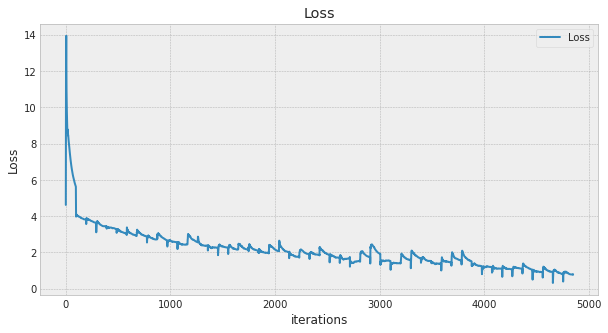

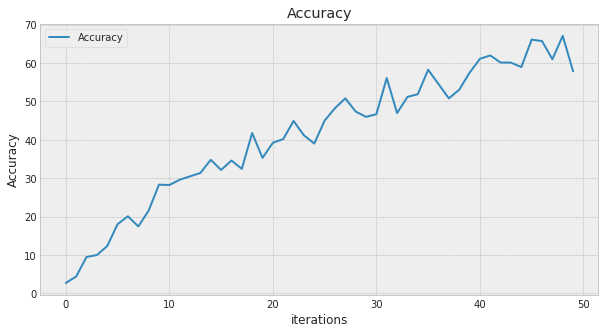

	Activate function : leaky_r

Epoch:1
	Batch:097 of 97, loss:3.205, MeanLoss:4.91679
	Accuracy of the network on the 10000 test images: 5.392 %

Epoch:2
	Batch:097 of 97, loss:3.718, MeanLoss:3.642
	Accuracy of the network on the 10000 test images: 9.412 %

Epoch:3
	Batch:097 of 97, loss:2.609, MeanLoss:3.468
	Accuracy of the network on the 10000 test images: 11.275 %

Epoch:4
	Batch:097 of 97, loss:2.972, MeanLoss:3.287
	Accuracy of the network on the 10000 test images: 13.627 %

Epoch:5
	Batch:097 of 97, loss:4.387, MeanLoss:3.170
	Accuracy of the network on the 10000 test images: 13.627 %

Epoch:6
	Batch:097 of 97, loss:4.564, MeanLoss:3.098
	Accuracy of the network on the 10000 test images: 15.980 %

Epoch:7
	Batch:097 of 97, loss:3.238, MeanLoss:2.891
	Accuracy of the network on the 10000 test images: 24.118 %

Epoch:8
	Batch:097 of 97, loss:2.188, MeanLoss:2.730
	Accuracy of the network on the 10000 test images: 23.627 %

Epoch:9
	Batch:097 of 97, loss:4.761, MeanLoss:2.692
	Accu

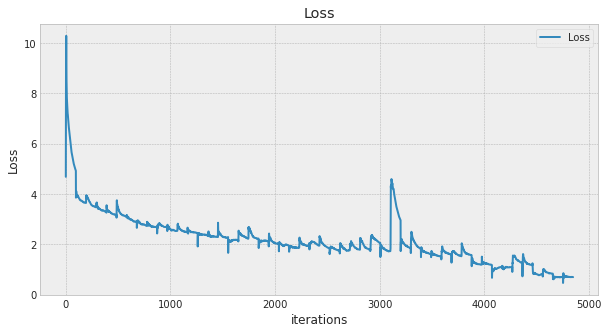

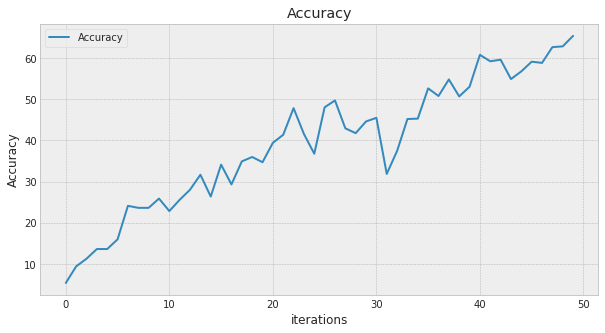

	Activate function : elu


In [16]:
for f in activate_f_list:
    net4 = choise_net(flower_Net, f, True) #original model
    net4.apply(weights_reset)
    Optim, schedul = choise_optim(net4, 'adam')

    train_part(net4, flower_trainloader, flower_testloader, CrossEntropy, Optim, 50, True)
    print(f'\tActivate function : {f}')